# DNS Tunneling Detection using XGBoost & Random Forest

**Dataset**: 4 CSV files (normal + iodine TXT/NULL + dnscat2)
**Features Used**: 11 highly discriminative features (entropy, length, EDNS0, etc.)

In [ ]:
!pip install xgboost scikit-learn pandas numpy matplotlib seaborn -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Preprocessing (Embedded - Runs directly on 4 CSVs)

A function (shannon_entropy) is defined to calculate the entropy of a DNS query. Entropy measures the randomness or unpredictability of the query string. It helps in distinguishing between normal and tunneling DNS queries.

In [ ]:
import pandas as pd
import numpy as np
import ast
import os
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

DATA_PATH = '/content/drive/MyDrive/Thesis_Dataset'

files_with_labels = {
    'normal_dns_full.csv': 0,
    'txt_dataset_full.csv': 1,
    'null_dataset_full.csv': 1,
    'dnscat2_full.csv': 1
}

MALICIOUS_BASE_DOMAIN = 'tunnel.devgossips.me'

def p_OF_X(count,length):
  return count / length;

def shannon_entropy(data):
    if not data or len(data) == 0:
        return 0.0
    counter = Counter(data)
    length = len(data)
    return -sum(p_OF_X(count,length) * np.log2(p_OF_X(count,length)) for count in counter.values())

def safe_literal_eval(x):
    if pd.isna(x):
        return {}
    try:
        return ast.literal_eval(str(x))
    except:
        return {}

def extract_query(row):
    queries_str = row.get('dns.Queries') or row.get('Queries', '')
    queries = safe_literal_eval(queries_str)
    if isinstance(queries, dict) and queries:
        first = list(queries.values())[0]
        name = first.get('dns.qry.name', '')
        qtype = first.get('dns.qry.type')
        name_len = first.get('dns.qry.name.len', len(name) if name else 0)
        labels = first.get('dns.count.labels', name.count('.') + 1 if name else 0)
        return name, qtype, int(name_len) if name_len else 0, int(labels) if labels else 0
    return '', None, 0, 0

def extract_edns0(row):
    add_str = row.get('dns.Additional records') or row.get('Additional records', '')
    add = safe_literal_eval(add_str)
    if isinstance(add, dict):
        for v in add.values():
            if v.get('dns.resp.type') == '41' or 'type OPT' in str(v):
                size = v.get('dns.rr.udp_payload_size', 0)
                return True, int(size) if size else 0
    return False, 0

def is_response(row):
    flags = str(row.get('dns.flags', '') or row.get('dns.dns.flags', '0'))
    if '0x' in flags:
        try:
            return int(flags.split('0x')[-1][:4], 16) & 0x8000 != 0
        except:
            pass
    return False

dfs = []
for filename, label in files_with_labels.items():
    filepath = os.path.join(DATA_PATH, filename)
    print(f"Loading {filepath}...")
    df = pd.read_csv(filepath, low_memory=False)
    df['label'] = label

    query_data = df.apply(extract_query, axis=1)
    df['qry_name_full'] = query_data.apply(lambda x: x[0])
    df['qry_type'] = query_data.apply(lambda x: x[1] if x[1] is not None else -1)
    df['qry_name_len'] = query_data.apply(lambda x: x[2])
    df['label_count'] = query_data.apply(lambda x: x[3])

    def clean_domain(name):
        if not name: return ''
        lower = name.lower()
        if MALICIOUS_BASE_DOMAIN in lower:
            return lower.split('.' + MALICIOUS_BASE_DOMAIN)[0]
        parts = name.split('.')
        return '.'.join(parts[-2:]) if len(parts) >= 2 else name

    df['qry_name_clean'] = df['qry_name_full'].apply(clean_domain)
    df['qry_entropy'] = df['qry_name_clean'].apply(lambda x: shannon_entropy(x.encode('utf-8', errors='ignore')))
    df['hex_ratio'] = df['qry_name_clean'].apply(lambda x: sum(c in '0123456789abcdefABCDEF' for c in x) / len(x) if len(x)>0 else 0)
    df['printable_ratio'] = df['qry_name_clean'].apply(lambda x: sum(32 <= ord(c) <= 126 for c in x) / len(x) if len(x)>0 else 0)

    edns_data = df.apply(extract_edns0, axis=1)
    df['has_edns0'] = edns_data.apply(lambda x: x[0])
    df['edns0_size'] = edns_data.apply(lambda x: x[1])

    df['udp_len'] = pd.to_numeric(df.get('udp.udp.length', 0), errors='coerce').fillna(0)
    df['ip_len'] = pd.to_numeric(df.get('ip.ip.len', 0), errors='coerce').fillna(0)
    df['is_response'] = df.apply(is_response, axis=1).astype(int)

    dfs.append(df)

full = pd.concat(dfs, ignore_index=True)
final_features = ['qry_name_len','qry_type','label_count','udp_len','ip_len','qry_entropy','hex_ratio','printable_ratio','has_edns0','edns0_size','is_response']
full['qry_type'] = pd.to_numeric(full['qry_type'], errors='coerce').fillna(-1)

data = full[final_features + ['label']].copy()
data.to_csv('dns_tunneling_ready.csv', index=False)
print(f"Preprocessed dataset saved: {len(data)} samples ({sum(data.label==0)} normal, {sum(data.label==1)} tunneled)")

Loading /content/drive/MyDrive/Thesis_Dataset/normal_dns_full.csv...
Loading /content/drive/MyDrive/Thesis_Dataset/txt_dataset_full.csv...
Loading /content/drive/MyDrive/Thesis_Dataset/null_dataset_full.csv...
Loading /content/drive/MyDrive/Thesis_Dataset/dnscat2_full.csv...
Preprocessed dataset saved: 5503 samples (3074 normal, 2429 tunneled)


## 2. Load & Split Data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

X = data.drop('label', axis=1)
y = data['label']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

Train: 3852 | Val: 825 | Test: 826


## 3. Train XGBoost & Random Forest

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# XGBoost
xgb = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, eval_metric='logloss')
xgb.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

print("Models trained!")

Models trained!


## 4. Evaluation & Visualizations


=== XGBoost Results ===
Accuracy : 0.990315
Precision: 0.981132
Recall   : 0.997260
F1 Score : 0.989130
ROC-AUC  : 0.999539


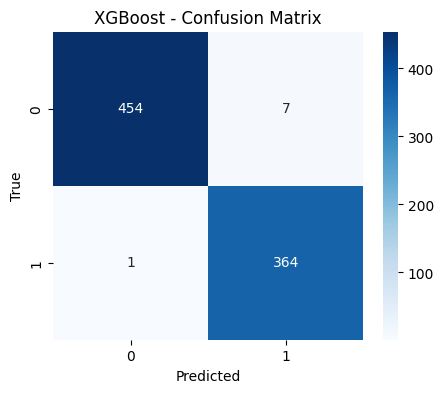

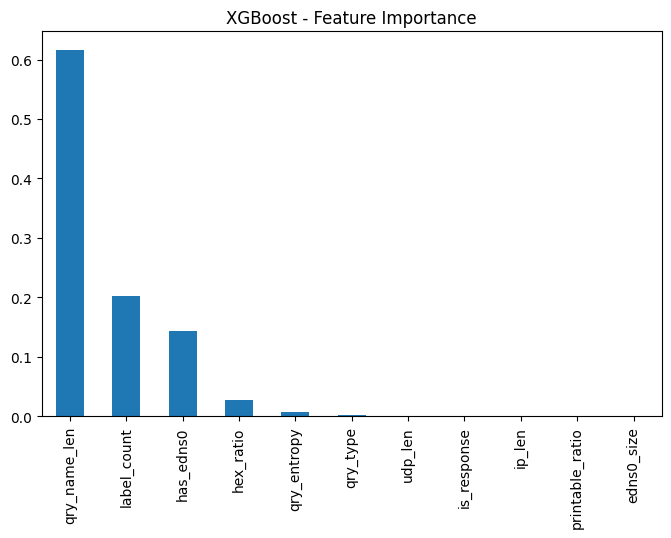


=== Random Forest Results ===
Accuracy : 0.992736
Precision: 0.983827
Recall   : 1.000000
F1 Score : 0.991848
ROC-AUC  : 0.999498


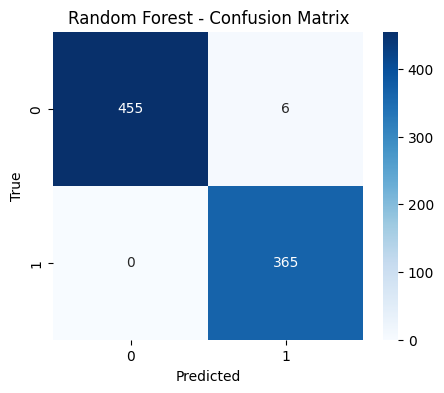

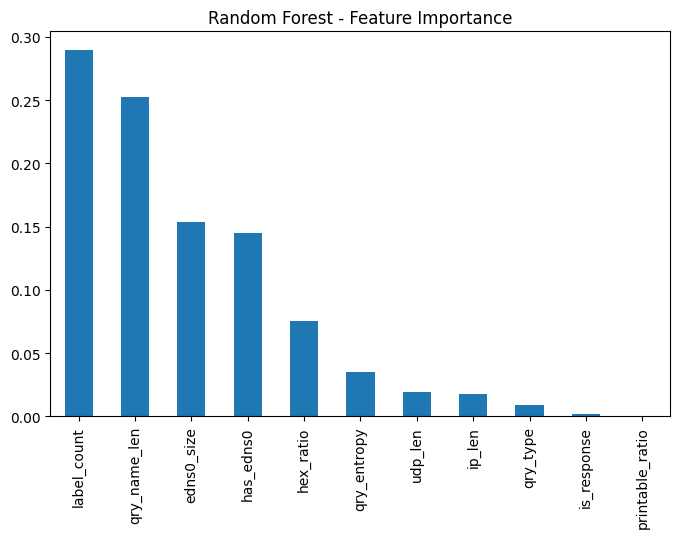

In [ ]:
def evaluate(model, name):
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[:, 1]

    print(f"\n=== {name} Results ===")
    print(f"Accuracy : {accuracy_score(y_test, pred):.6f}")
    print(f"Precision: {precision_score(y_test, pred):.6f}")
    print(f"Recall   : {recall_score(y_test, pred):.6f}")
    print(f"F1 Score : {f1_score(y_test, pred):.6f}")
    print(f"ROC-AUC  : {roc_auc_score(y_test, prob):.6f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

    # Feature Importance
    imp = pd.Series(model.feature_importances_ if hasattr(model, 'feature_importances_') else model.estimators_[0].feature_importances_,
                    index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(8,5))
    imp.plot(kind='bar')
    plt.title(f'{name} - Feature Importance')
    plt.show()

evaluate(xgb, "XGBoost")
evaluate(rf, "Random Forest")